In [1]:
from itertools import product
from utils.binaries import *
from utils.plotting import *
import os

14:29:02 (   +1.4s) [INFO   ] -- import logging
14:29:02 (    +2ms) [INFO   ] -- import numpy as np
14:29:02 (    +2ms) [INFO   ] -- import numpy as np
14:29:02 (    +9ms) [INFO   ] -- import uncertainties
14:29:02 (  +234ms) [INFO   ] -- import pandas as pd
14:29:02 (    +1ms) [WARNING] -- pandas support to be dropped at some point!
14:29:02 (    +2ms) [INFO   ] -- import binaries.tools as tools
14:29:02 (  +291ms) [INFO   ] -- import matplotlib.pyplot as plt
14:29:03 (  +341ms) [INFO   ] -- import seaborn as so
14:29:03 (    +2ms) [INFO   ] -- import plotting.tools as plot
14:29:03 (    +7ms) [DEBUG  ] -- font size set to 9.5
14:29:03 (    +1ms) [DEBUG  ] -- label size set to 13.0
14:29:03 (    +1ms) [DEBUG  ] -- figure size set to [6.6, 3.3]
14:29:03 (    +1ms) [DEBUG  ] -- markersize set to 2.0
14:29:03 (    +0ms) [DEBUG  ] -- usetex set to False


In [6]:
def visualize(z_close, z_far, max_scale, l=None):

    from matplotlib.colorbar import ColorbarBase
    from matplotlib.colors import CenteredNorm

    multiplicities = range(5, 45)
    threshold = np.linspace(0.05, 3.00, 295)

    z_close = z_close.reshape((len(multiplicities), len(threshold)))
    z_far = z_far.reshape((len(multiplicities), len(threshold)))
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

    for ax, z, distance in zip([ax1, ax2], [z_close, z_far], ['$<750\,$m', '$\geq750\,$m']):

        ax.set_box_aspect(1)
        image = ax.imshow(z.T, extent=(5, 45, 0.05, 3.00), 
                          aspect='auto', 
                          cmap='coolwarm', 
                          origin='lower',
                          interpolation='none',
                          vmin=-1, vmax=1)

        ax.set_title(distance)
        ax.set_xlabel('occupancy / bins')
        ax.set_yscale('log')
        _ = ax.set_yticks([0.2, 0.3, 0.4, 0.6, 0.8, 1.0, 2.0],["0.2", "0.3", "0.4", "0.6", "0.8", "1.0", "2.0"])
        ax.minorticks_off()

    ax1.set_ylabel('threshold / $I^\mathrm{SSD}_\mathrm{histo}$')

    cax = fig.add_axes([0.97, 0.1, 0.03, 0.8])
    norm = CenteredNorm(0, max_scale)

    ColorbarBase(cax, norm=norm, cmap=plt.cm.coolwarm, 
                 label=r"$\left(\mathrm{T2}_\mathrm{SSD}-\mathrm{T2}_\mathrm{WCD}\right)\,/\,n_\mathrm{Candidate}$")


In [7]:
run_no = "photon"
src_dir = f"/cr/work/filip/SSDTriggerEfficiency/{run_no}_evaluated"
all_files = [f"{src_dir}/{file}" for file in os.listdir(src_dir)]

df = pd.read_csv(all_files[0], index_col="params")
for file in tools.ProgressBar(all_files[1:]):
    df += pd.read_csv(file, index_col="params")



278/278 [********************] || 00:00:02>00:00:00,       101.42 it/s


In [8]:
multiplicities = range(5, 45)
threshold = np.linspace(0.05, 3.00, 295)
all_params = list(product(multiplicities, threshold))

container = np.empty((4, len(all_params)))
container[:] = np.nan
x, y, z_close, z_far = container
max_scale = -np.inf
for index, row in df.iterrows():
    x_, y_ = [float(_) for _ in index[1:-1].split(',')]
    for i, (_x, _y) in enumerate(all_params):
        if _x == x_ and _y == y_: break

    f_far = row.sum_far / row.n_far
    f_close = row.sum_close / row.n_close

    this_max = max(np.max(f_far), np.max(f_close),
                   np.abs(np.min(f_far)), 
                   np.abs(np.min(f_close)))
    if this_max > max_scale: 
        max_scale = this_max

    x[i] = x_
    y[i] = y_
    z_far[i] = f_far
    z_close[i] = f_close

z_close /= max_scale
z_far /= max_scale

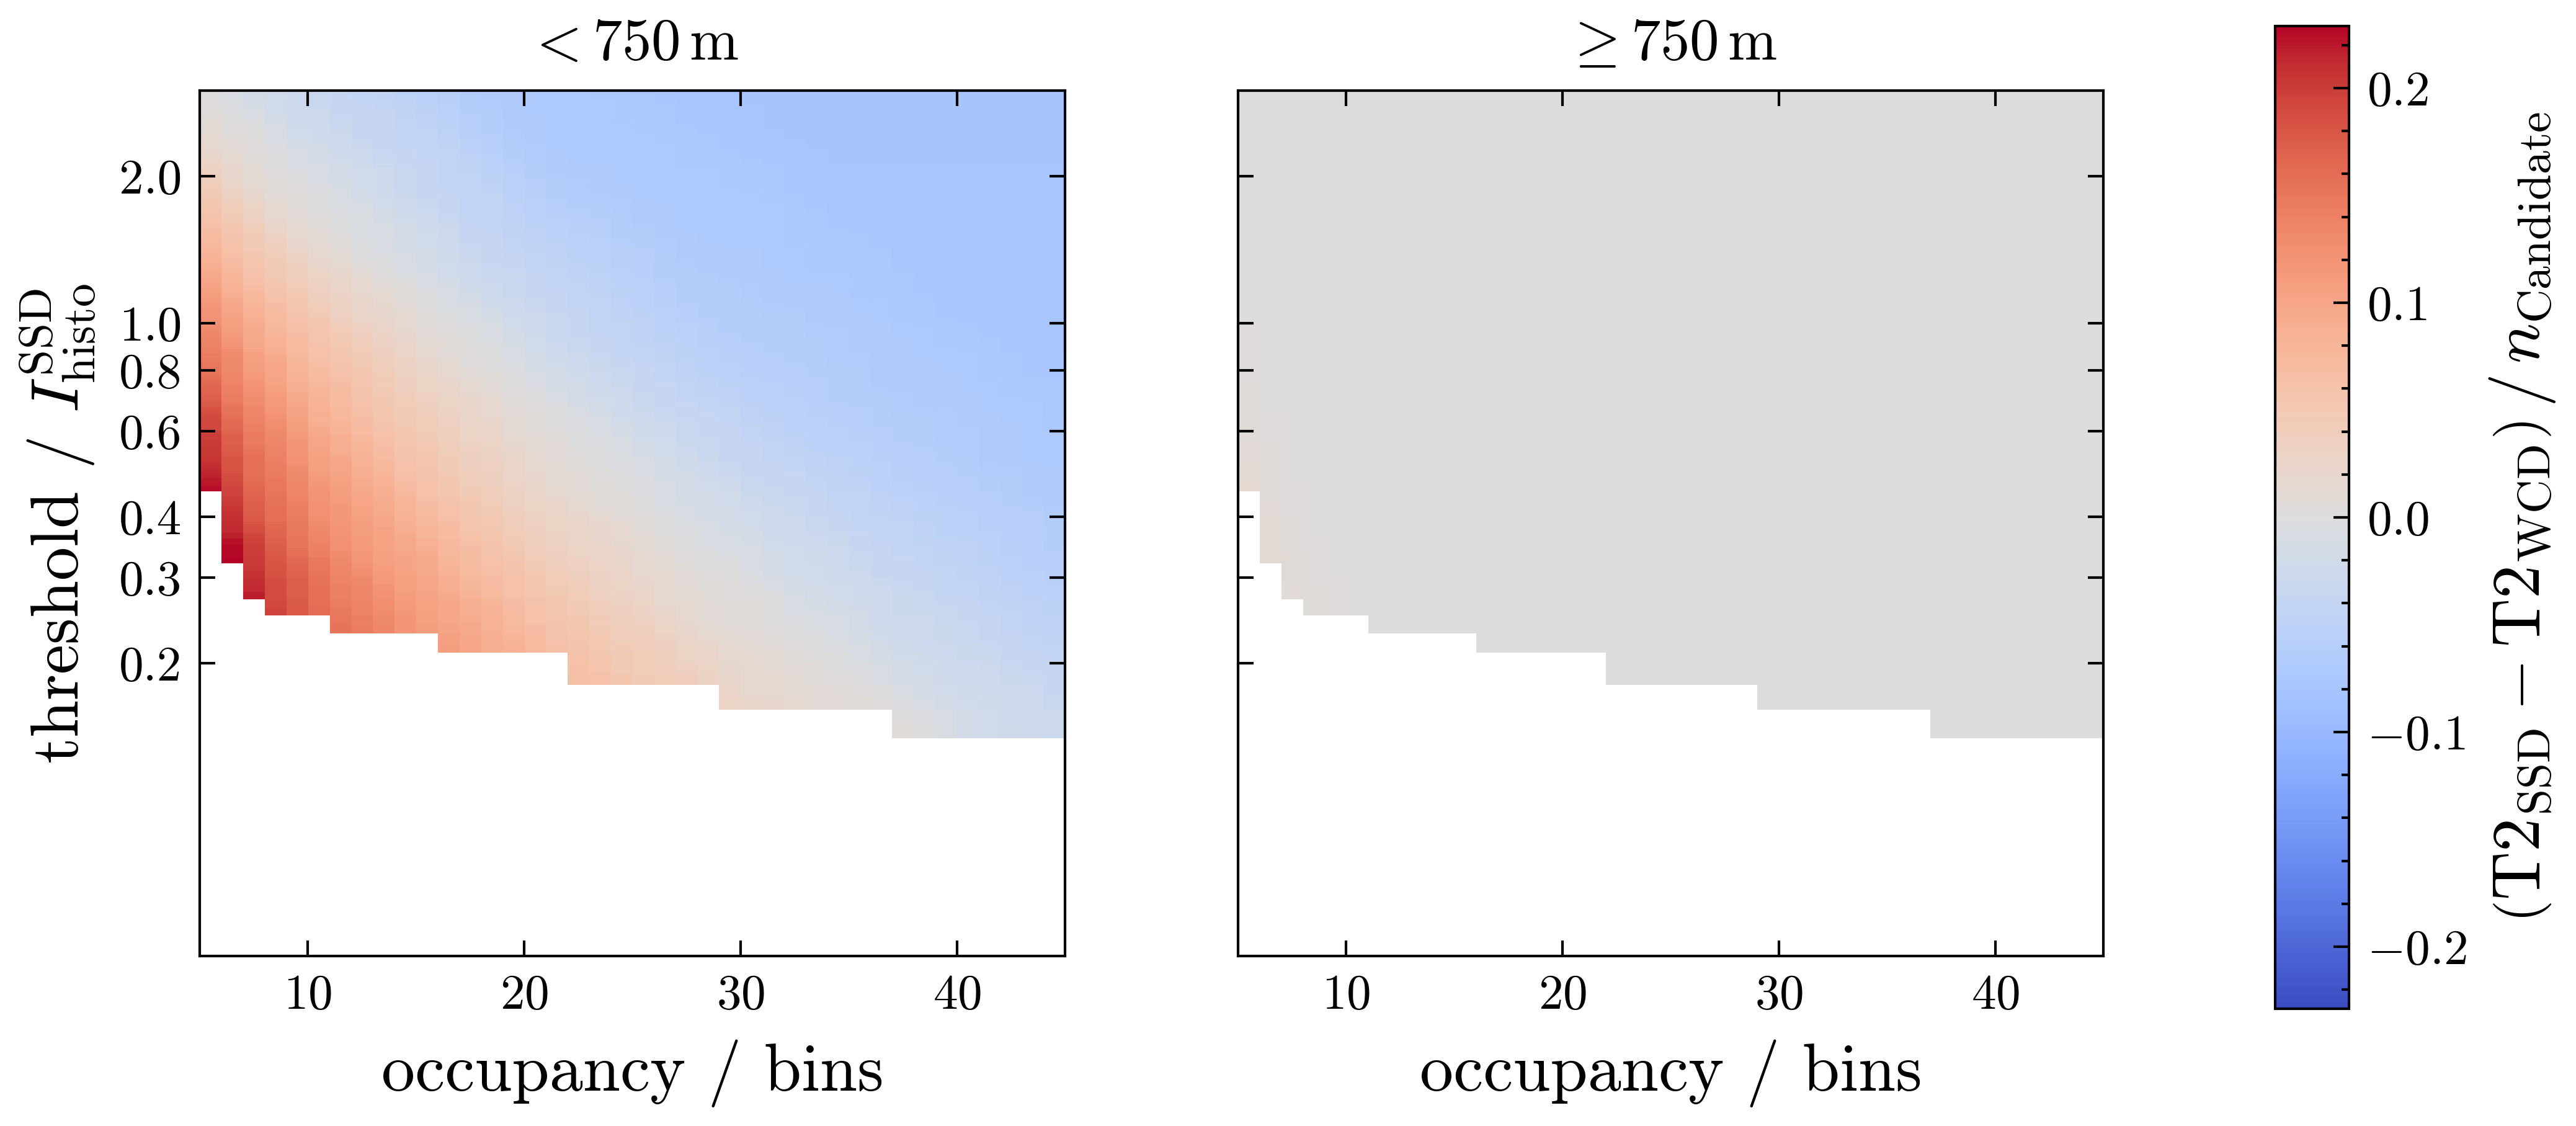

In [9]:
visualize(z_close, z_far, max_scale)